In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, TimeDistributed, BatchNormalization, MaxPooling1D, Reshape

def generate_synthetic_data(num_points, snapshots, predict_snapshots):
    time_points = np.linspace(0, 2 * np.pi, snapshots + predict_snapshots)
    space_points = np.linspace(0, 2 * np.pi, num_points)
    T, S = np.meshgrid(time_points, space_points, indexing='ij')
    
    density = np.sin(T) * np.cos(S)
    velocity = np.sin(T + np.pi / 4) * np.cos(S)
    temperature = np.sin(T + np.pi / 2) * np.cos(S)
    
    data = np.stack([density, velocity, temperature], axis=-1)
    X = data[:snapshots]  # Features
    Y = data[snapshots:snapshots + predict_snapshots]  # Labels for prediction
    return X, Y

def build_model(snapshots, num_points, output_shape):
    input_shape = (snapshots, num_points, 3)  # 3 channels for density, velocity, temperature
    
    model = Sequential([
        TimeDistributed(Conv1D(64, 3, activation='relu'), input_shape=input_shape),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling1D(2)),
        TimeDistributed(Conv1D(128, 3, activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling1D(2)),
        TimeDistributed(Flatten()),
        LSTM(128, return_sequences=False),
        Dense(np.prod(output_shape), activation='linear'),  # Flatten the output
        Reshape(output_shape)  # Reshape output to the desired shape
    ])
    
    model.compile(optimizer='adam', loss='mse')
    return model

def plot_predictions(actual, predicted, field_index, field_name):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(14, 6))
    actual_last = actual[-1, :, field_index]
    predicted_first = predicted[0, :, field_index]
    
    plt.plot(actual_last, label=f'Actual Last {field_name}', marker='o')
    plt.plot(predicted_first, label=f'Predicted First {field_name}', marker='x')
    
    plt.title(f'Actual vs Predicted {field_name}')
    plt.xlabel('Spatial Points')
    plt.ylabel(field_name)
    plt.legend()
    plt.show()

# Parameters
num_points = 100
snapshots = 40
predict_snapshots = 10

# Generate synthetic data
X, Y = generate_synthetic_data(num_points, snapshots, predict_snapshots)

# Define model
model = build_model(snapshots, num_points, (predict_snapshots, num_points, 3))

# Normally, you'd train your model here
model.fit(X, Y, epochs=10, validation_split=0.2)

# Using Y as "predicted" data for demonstration purposes
plot_predictions(Y, Y, 0, 'Density')

ValueError: Data cardinality is ambiguous:
  x sizes: 32
  y sizes: 10
Make sure all arrays contain the same number of samples.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)



TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")




def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)



    def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        
        ### START CODE HERE
        
        # Create a CSV reader with a specific delimiter (e.g., ',' or '\t')
        reader = csv.reader(csvfile, delimiter=',')
        
        # Skip the header row (if it exists)
        next(reader)
        
        # Iterate through each row in the CSV file
        for row in reader:
            # Extract the temperature value and convert it to a float
            temperature = float(row[1])
            temperatures.append(temperature)
            
            # Append the time step (starting at zero)
            times.append(len(temperatures) - 1)
        ### END CODE HERE
            
    return times, temperatures



# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()



def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)



def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)



def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[None, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ]) 
    
    ### END CODE HERE

    return model



# You can test your model with the code below. 
# If you get an error, it's likely that your model is returning a sequence. 
# You can indeed use an LSTM with `return_sequences=True` but you have to feed it into another layer that generates a single prediction. 
# You can review the lectures or the previous ungraded labs to see how that is done.

# Test your uncompiled model

# Create an instance of the model
uncompiled_model = create_uncompiled_model()

# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):
    
    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)
    
# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")



## Adjusting the learning rate - (Optional Exercise)

# As you saw in the lectures, you can leverage Tensorflow's callbacks to dynamically vary the learning rate before doing the actual training. 
# This can be helpful in finding what value works best with your model. 
# Note that this is only one way of finding the best learning rate. 
# There are other techniques for hyperparameter optimization but it is outside the scope of this course.

# For the optimizers you can try out:

# - tf.keras.optimizers.Adam
# - tf.keras.optimizers.SGD with a momentum of 0.9

def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history



# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)


plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])



## Compiling the model
# Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. 
# For this complete the `create_model` function below.

# Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. 
# Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

# Hints:
# - The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.
# - If after the first epoch you get an output like this: loss: nan - mae: nan it is very likely that your network is suffering from exploding gradients. 
# This is a common problem if you used SGD as optimizer and set a learning rate that is too high. 

# If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.



def create_model():
    
    model = create_uncompiled_model()

    ### START CODE HERE
    learning_rate = 5e-4
    
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
                  metrics=["mae"])
    

    ### END CODE HERE

    return model



# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)



## Evaluating the forecast

# Now it is time to evaluate the performance of the forecast. 
# For this you can use the `compute_metrics` function that you coded in a previous assignment:

def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

# At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast.



## Faster model forecasts

# In the previous week you saw a faster approach compared to using a for loop to compute the forecasts for every point in the sequence. 
# Remember that this faster approach uses batches of data. 

# The code to implement this is provided in the `model_forecast` below. 
# Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:
# - The dataset is windowed using `window_size` rather than `window_size + 1`
# - No shuffle should be used
# - No need to split the data into features and labels
# - A model is used to predict batches of the dataset


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast




# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)




mse, mae = compute_metrics(series_valid, rnn_forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

Epoch 1/20
78/78 [==============================] - 5s 25ms/step - loss: 0.2199 - mae: 0.5915
Epoch 2/20
78/78 [==============================] - 2s 26ms/step - loss: 0.1296 - mae: 0.4366
Epoch 3/20
78/78 [==============================] - 2s 26ms/step - loss: 0.0643 - mae: 0.2901
Epoch 4/20
78/78 [==============================] - 2s 26ms/step - loss: 0.0350 - mae: 0.2157
Epoch 5/20
78/78 [==============================] - 3s 36ms/step - loss: 0.0235 - mae: 0.1796
Epoch 6/20
78/78 [==============================] - 3s 33ms/step - loss: 0.0191 - mae: 0.1625
Epoch 7/20
78/78 [==============================] - 3s 33ms/step - loss: 0.0170 - mae: 0.1532
Epoch 8/20
78/78 [==============================] - 3s 32ms/step - loss: 0.0158 - mae: 0.1470
Epoch 9/20
78/78 [==============================] - 3s 34ms/step - loss: 0.0150 - mae: 0.1430
Epoch 10/20
78/78 [==============================] - 3s 31ms/step - loss: 0.0144 - mae: 0.1402
Epoch 11/20
78/78 [==============================] - 3s 32m

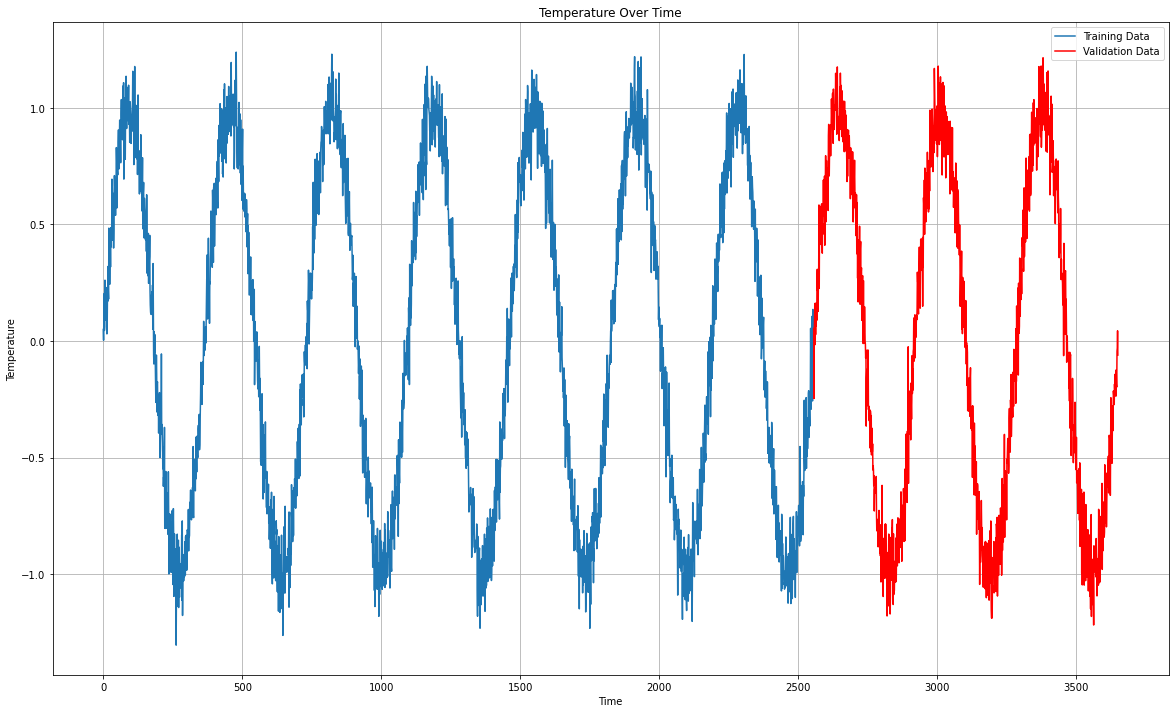

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Assuming temperatures and timestamps are available as NumPy arrays
# For example purposes, let's generate some dummy data
np.random.seed(42)  # For reproducible results
timestamps = np.arange(0, 3650)  # Representing 10 years of daily data
temperatures = np.sin(timestamps * 2 * np.pi / 365) + np.random.normal(0, 0.1, len(timestamps))

# Function to plot a series of data points
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

# Data class to hold global variables and parsed data
@dataclass
class G:
    TIME = timestamps
    SERIES = temperatures
    SPLIT_TIME = int(len(timestamps) * 0.7)  # 70% for training, 30% for validation
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

# Split dataset into training and validation sets
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
    return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

# Function to prepare windowed dataset for model training
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

train_set = windowed_dataset(series_train)

# Model architecture remains the same as in your previous code
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation="relu", padding='causal', input_shape=[None, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ])

    learning_rate = 5e-4
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
                  metrics=["mae"])

    return model

model = create_model()
history = model.fit(train_set, epochs=20)

# Forecasting and evaluation functions remain the same
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

def compute_metrics(true_series, forecast):
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    return mse, mae

mse, mae = compute_metrics(series_valid, rnn_forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

# Split data: 70% for training and 30% for validation
split_time = int(len(timestamps) * 0.7)
time_train, series_train = timestamps[:split_time], temperatures[:split_time]
time_valid, series_valid = timestamps[split_time:], temperatures[split_time:]

# Plot training and validation series
plt.figure(figsize=(20, 12))
plt.plot(time_train, series_train, label='Training Data')
plt.plot(time_valid, series_valid, label='Validation Data', color='red')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Assuming temperatures and timestamps are available as NumPy arrays
# For example purposes, let's generate some dummy data
np.random.seed(42)  # For reproducible results
timestamps = np.arange(0, 3650)  # Representing 10 years of daily data
temperatures = np.sin(timestamps * 2 * np.pi / 365) + np.random.normal(0, 0.1, len(timestamps))

# Function to plot a series of data points
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

# Data class to hold global variables and parsed data
@dataclass
class G:
    TIME = timestamps
    SERIES = temperatures
    SPLIT_TIME = int(len(timestamps) * 0.7)  # 70% for training, 30% for validation
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

# Split dataset into training and validation sets
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
    return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

# Function to prepare windowed dataset for model training
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

train_set = windowed_dataset(series_train)

# Model architecture remains the same as in your previous code
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation="relu", padding='causal', input_shape=[None, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ])

    learning_rate = 5e-4
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
                  metrics=["mae"])

    return model

model = create_model()
history = model.fit(train_set, epochs=20)

# Forecasting and evaluation functions remain the same
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

def compute_metrics(true_series, forecast):
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    return mse, mae

mse, mae = compute_metrics(series_valid, rnn_forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

# Split data: 70% for training and 30% for validation
split_time = int(len(timestamps) * 0.7)
time_train, series_train = timestamps[:split_time], temperatures[:split_time]
time_valid, series_valid = timestamps[split_time:], temperatures[split_time:]

# Plot training and validation series
plt.figure(figsize=(20, 12))
plt.plot(time_train, series_train, label='Training Data')
plt.plot(time_valid, series_valid, label='Validation Data', color='red')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')
plt.legend()
plt.grid(True)
plt.show()

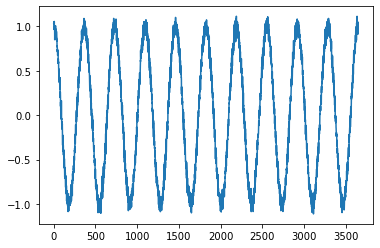

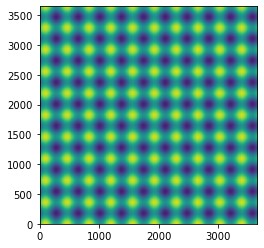

(3650,)
(3650, 3650)
Epoch 1/20


ValueError: in user code:

    File "c:\Users\chris\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\chris\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\chris\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\chris\anaconda3\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\chris\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\chris\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_18" is incompatible with the layer: expected shape=(None, None, 2), found shape=(None, None, 3650)


In [20]:
def create_model_2d():
    model = tf.keras.models.Sequential([
        # Adjust the input shape to include the number of features per timestep. 
        # For example, if there are 2 features (temperature and humidity),
        # the input shape would be [None, 2].
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation="relu", padding='causal', input_shape=[None, 2]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)  # Assuming we're still predicting a single value
    ])

    learning_rate = 5e-4
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
                  metrics=["mae"])

    return model

# Assuming you have a second feature ready, let's generate dummy humidity data
humidity = np.cos(timestamps * 2 * np.pi / 365) + np.random.normal(0, 0.05, len(timestamps))

# Stack temperature and humidity together along the last dimension to form 2D data
data = humidity[:, np.newaxis] + temperatures[np.newaxis,:]

plt.figure()
plt.imshow(data, origin='lower', aspect='equal')
plt.show()

print(np.shape(temperatures))
print(np.shape(data))

# Update the dataset preparation functions accordingly
def windowed_dataset_2d(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))  # Note: Adjust if predicting different structure
    ds = ds.batch(batch_size).prefetch(1)
    return ds

# Since the model now expects 2D input, ensure the dataset matches this expectation
train_set_2d = windowed_dataset_2d(data[:split_time], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

# Instantiate and train the updated model
model_2d = create_model_2d()
history_2d = model_2d.fit(train_set_2d, epochs=20)

In [29]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming temperatures and timestamps are as defined earlier
np.random.seed(42)
timestamps = np.arange(0, 3650)  # 10 years of daily data
spatiostamps = np.arange(0, 1000)  # 10 years of daily data

temperatures = np.sin(timestamps * 2 * np.pi / 365) + np.random.normal(0, 0.1, len(timestamps))

# Generate dummy humidity data
humidity = np.cos(spatiostamps * 2 * np.pi / 365) + np.random.normal(0, 0.05, len(spatiostamps))

# Stack temperature and humidity together to form 2D data
data = humidity[:, np.newaxis] + temperatures[np.newaxis,:]

# Split data: 70% for training and 30% for validation
split_time = int(len(timestamps) * 0.7)
data_train, data_valid = data[:, :split_time], data[:, split_time:]
time_train, time_valid = timestamps[:split_time], timestamps[split_time:]

def graph_spatiotemporal_reults(data, split_time):
    # Combining training and validation data in the same plot using masked arrays to apply different colormaps
    from numpy.ma import masked_array

    # Create masked arrays for training and validation data
    data_train_masked = masked_array(data, mask=True)
    data_train_masked[:, :split_time] = data[:, :split_time]
    data_valid_masked = masked_array(data, mask=True)
    data_valid_masked[:, split_time:] = data[:, split_time:]

    # Plotting both training and validation data on the same graph
    plt.figure(figsize=(10, 6))

    # Apply the first colormap (viridis) for the training data
    plt.imshow(data_train_masked, cmap='viridis', aspect='auto')

    # Apply the second colormap (plasma) for the validation data
    plt.imshow(data_valid_masked, cmap='plasma', aspect='auto', alpha=0.7)  # alpha for slight transparency

    plt.colorbar(label='Combined Temperature and Humidity')
    plt.xlabel('Time Dimension')
    plt.ylabel('Spatial Dimension')
    plt.title('Combined Training and Validation Data')
    plt.show()

# Function to prepare windowed dataset for model training with 2D data
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

# Adjust the model to handle 2D input data
def create_model(input_shape=(spatiostamps, timestamps, 1)):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same", input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        # Additional layers as needed...
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create and train the model
WINDOW_SIZE = 64
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_set = windowed_dataset(data_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)
input_shape = (data.shape[0], data.shape[1], 1)
model = create_model(input_shape=input_shape)
history = model.fit(train_set, epochs=10)


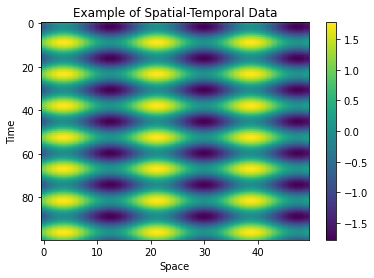

Epoch 1/50
25/25 [==============================] - 10s 128ms/step - loss: 0.3362 - val_loss: 0.3282
Epoch 2/50
25/25 [==============================] - 2s 70ms/step - loss: 0.3030 - val_loss: 0.2911
Epoch 3/50
25/25 [==============================] - 2s 67ms/step - loss: 0.2636 - val_loss: 0.2619
Epoch 4/50
25/25 [==============================] - 2s 61ms/step - loss: 0.2317 - val_loss: 0.2422
Epoch 5/50
25/25 [==============================] - 2s 63ms/step - loss: 0.2015 - val_loss: 0.2317
Epoch 6/50
25/25 [==============================] - 1s 57ms/step - loss: 0.1744 - val_loss: 0.2071
Epoch 7/50
25/25 [==============================] - 1s 59ms/step - loss: 0.1486 - val_loss: 0.1865
Epoch 8/50
25/25 [==============================] - 1s 59ms/step - loss: 0.1304 - val_loss: 0.1697
Epoch 9/50
25/25 [==============================] - 2s 62ms/step - loss: 0.1137 - val_loss: 0.1618
Epoch 10/50
25/25 [==============================] - 2s 63ms/step - loss: 0.0991 - val_loss: 0.1356
Epoch 1

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(0)

# Parameters
num_samples = 1000  # number of training samples
num_points = 50     # number of spatial points
time_steps = 100    # number of time snapshots
predicted_snapshots = 10  # number of time snapshots to predict

# Generate randomized features to vary datasets
sin_Amp = np.random.uniform(0, 1, num_samples)
cos_Amp = np.random.uniform(0, 1, num_samples)
sin_freq = np.random.uniform(0, 1, num_samples)
cos_freq = np.random.uniform(0, 1, num_samples)
sin_phase = np.random.uniform(0, 1, num_samples)
cos_phase = np.random.uniform(0, 1, num_samples)

# Create training data
time = np.linspace(0, 10, time_steps)  # time vector
space = np.linspace(0, 10, num_points)  # space vector

# Using broadcasting to create the grid of values
X_train = np.zeros((num_samples, time_steps, num_points))
for i in range(num_samples):    
    # Calculate the spatial-temporal field for each sample and assign to X_train
    X_train[i, :, :] = sin_Amp[i] * np.sin(2 * np.pi * sin_freq[i] * (time[:, None] - sin_phase[i])) + \
                       cos_Amp[i] * np.cos(2 * np.pi * cos_freq[i] * (space[None, :] - cos_phase[i]))

# Example Data
plt.figure()
plt.imshow(X_train[300], aspect='auto')
plt.colorbar()
plt.title("Example of Spatial-Temporal Data")
plt.xlabel("Space")
plt.ylabel("Time")
plt.show()

# Neural Network Model
def create_model(input_shape, num_predictions):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(LSTM(64, return_sequences=True))  # LSTM should return sequences
    model.add(LSTM(64, return_sequences=False)) # Second LSTM to interpret the sequences
    model.add(Dense(num_predictions))  # Output layer with units for all predictions at once
    model.add(Reshape((predicted_snapshots, num_points)))  # Reshape the output to the desired format

    # Compile the model with an optimizer and loss function for regression
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# Since we're predicting future states, we'll need to re-organize our data
# The model will train on the first (time_steps - predicted_snapshots) to predict the last predicted_snapshots
X, Y = X_train[:, :time_steps-predicted_snapshots, :], X_train[:, time_steps-predicted_snapshots:, :]

# Define the input shape and number of predictions
input_shape = (time_steps - predicted_snapshots, num_points)
num_predictions = predicted_snapshots * num_points  # Total number of predictions to be made

# Create the model
model = create_model(input_shape, num_predictions)

# Train the model on the re-organized data
history = model.fit(X, Y, batch_size=32, epochs=50, validation_split=0.2, verbose=1)

(1000, 90, 50)
32/32 [==============================] - 3s 39ms/step


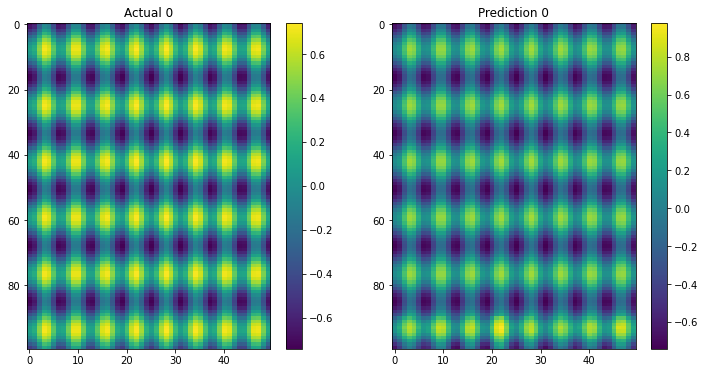

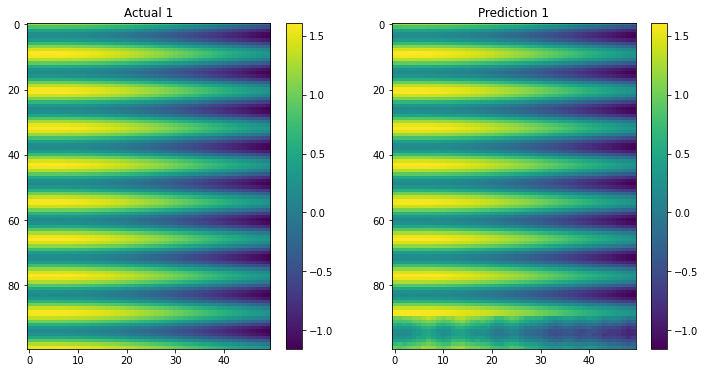

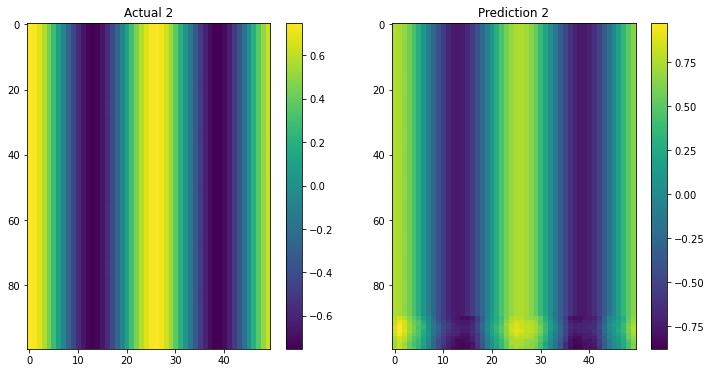

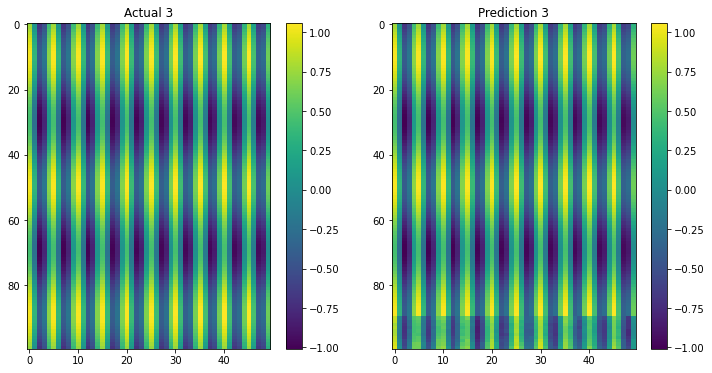

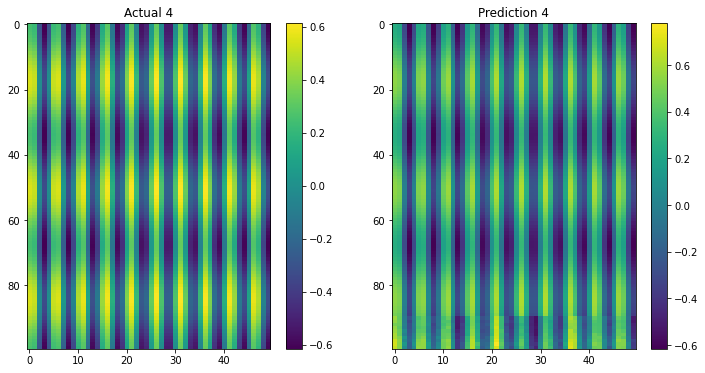

In [38]:
# Step 1: Generate a Second Dataset (X_test) with different parameters
np.random.seed(1)  # Change the seed for different random parameters

# Generate randomized features for the second dataset
sin_Amp_test = np.random.uniform(0, 1, num_samples)
cos_Amp_test = np.random.uniform(0, 1, num_samples)
sin_freq_test = np.random.uniform(0, 1, num_samples)
cos_freq_test = np.random.uniform(0, 1, num_samples)
sin_phase_test = np.random.uniform(0, 1, num_samples)
cos_phase_test = np.random.uniform(0, 1, num_samples)

# Create the second dataset (X_test)
X_test = np.zeros((num_samples, time_steps, num_points))
for i in range(num_samples):
    X_test[i, :, :] = sin_Amp_test[i] * np.sin(2 * np.pi * sin_freq_test[i] * (time[:, None] - sin_phase_test[i])) + \
                      cos_Amp_test[i] * np.cos(2 * np.pi * cos_freq_test[i] * (space[None, :] - cos_phase_test[i]))

# Step 2: Prepare the Second Dataset for Prediction
# We use the first (time_steps - predicted_snapshots) of each sequence as input for prediction
X_test_input = X_test[:, :time_steps-predicted_snapshots, :]

# Shapes for verification
print(X_test_input.shape)

X_test_input = X_test[:, :time_steps-predicted_snapshots, :]
Y_test_pred = model.predict(X_test_input)

for i in range(min(5, len(X_test))):  # Visualize the first 5 predictions
    plt.figure(figsize=(12, 6))

    # Actual
    plt.subplot(1, 2, 1)
    actual = np.concatenate((X_test[i, :time_steps-predicted_snapshots, :], X_test[i, time_steps-predicted_snapshots:, :]), axis=0)
    plt.imshow(actual, aspect='auto')
    plt.colorbar()
    plt.title(f"Actual {i}")

    # Prediction
    plt.subplot(1, 2, 2)
    prediction = np.concatenate((X_test[i, :time_steps-predicted_snapshots, :], Y_test_pred[i]), axis=0)
    plt.imshow(prediction, aspect='auto')
    plt.colorbar()
    plt.title(f"Prediction {i}")

    plt.show()
